# Sentiment Analysis with NLTK and VADER
# TODO: decide on 'I' vs 'we'

## Step 1: Load the input text

In [131]:
from pathlib import Path

# read and close the file in one line
# see https://stackoverflow.com/a/49564464
text_file = Path("input.txt").read_text()

# ensure that we've read the correct file
print("Read 50 characters of input file: " + text_file[0:50])

Read 50 characters of input file: "Stop blushing. I'm not needling, really I'm not. 


## Step 2: Split into two paragraphs and reformat text
The input text file seems to contain two paragraphs that I believe should be analyzed separately.
These paragraphs are seperated by double newlines, so I split them here.
The input text file also contains newlines to avoid any one line from being too long, so I then remove all the newlines.

In [132]:
# split into paragraphs and remove newlines inside paragraphs
# we also need to remove double-spaces because some lines end with a space
paragraphs = text_file.split("\n\n")
paragraphs = [paragraph.replace("\n", " ").replace("  ", " ") for paragraph in paragraphs]
print("Extracted {} paragraphs: '{}...' '{}...'".format(len(paragraphs), paragraphs[0][0:20], paragraphs[1][0:20]))

Extracted 2 paragraphs: '"Stop blushing. I'm ...' 'I think you may like...'


## Step 3: Calculating overall sentiment with NLTK and VADER
To begin, we calculate the overall sentiment of our input text with VADER, a sentiment
analysis tool built from the research of Hutto, C.J. & Gilbert.

### Step 3.1: Download & install
First, we must download the `vader_lexicon` NLTK resource.

In [133]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/max/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Step 3.2: Run analysis on input text
We rejoin the paragraphs and run the analysis:

In [134]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

paragraphs_together = "\n".join(paragraphs)
together_scores = analyzer.polarity_scores(paragraphs_together)

print("Got scores from paragraphs together {} ".format(together_scores))

Got scores from paragraphs together {'neg': 0.065, 'neu': 0.748, 'pos': 0.187, 'compound': 0.9982} 


### Step 3.3: Extract a single sentiment score
We will now extract a single sentiment score from the text. This value is in the range
`[-1, 1]`, with higher values signaling a more positive sentiment and lower values signaling
a more negative sentiment. The meaning of this score will be explained more in the conclusion.

In [135]:
single_sentiment_score = together_scores.get("compound")
print("Got single sentiment score: {}".format(single_sentiment_score))

Got single sentiment score: 0.9982


### Step 3.4: Run analysis on individual paragraphs
We now run the VADER analysis on each paragraph individually:

In [136]:
paragraphs_scores = [analyzer.polarity_scores(paragraph) for paragraph in paragraphs]

print("Got scores from individual paragraphs {} ".format(paragraphs_scores))

Got scores from individual paragraphs [{'neg': 0.124, 'neu': 0.731, 'pos': 0.145, 'compound': 0.521}, {'neg': 0.05, 'neu': 0.721, 'pos': 0.23, 'compound': 0.9981}] 


### Step 3.5: Visualize results
We leverage [Matplotlib](https://pypi.org/project/matplotlib/) to visualize our results in a stacked-bar chart.

In [155]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.ioff()

# we need to add 1 to the start and stop because otherwise our paragraphs would be 0-indexed
paras_list = list(range(1, len(paragraphs) + 1))

# create labels for each paragraph
paras_labels = ["Paragraph {}".format(para_num) for para_num in paras_list]
labels = ["Whole Text"] + paras_labels
print(labels)

# extract the scores from the paragraphs together and individually
positive_scores = [together_scores.get("pos")] + [score.get("pos") for score in paragraphs_scores]
neutral_scores = [together_scores.get("neu")] + [score.get("neu") for score in paragraphs_scores]
negative_scores = [together_scores.get("neg")] + [score.get("neg") for score in paragraphs_scores]

print(positive_scores, neutral_scores, negative_scores)

width = 0.35

['Whole Text', 'Paragraph 1', 'Paragraph 2']
[0.187, 0.145, 0.23] [0.748, 0.731, 0.721] [0.065, 0.124, 0.05]


Text(0.5, 1.0, 'Single sentiment score')

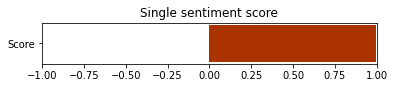

In [146]:
# create the first subplot: the single score
fig2, ax2 = plt.subplots()
ax2.barh("Score", single_sentiment_score, color="#aa3300")
# the score is [-1, 1] so make the chart reflect that
ax2.set_xbound(-1, 1)
fig2.set_figheight(.75)
ax2.set_title("Single sentiment score")

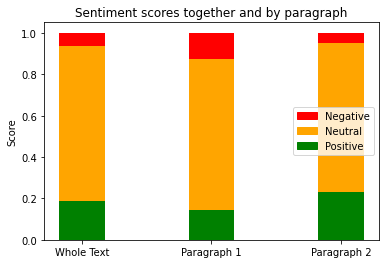

In [158]:
# create the second subplot: the score breakdowns
fig, ax = plt.subplots()
ax.bar(labels, positive_scores, width, label="Positive", color="green")
ax.bar(labels, neutral_scores, width, label="Neutral", bottom=positive_scores, color="orange")

# matplotlib expects that we sum the previous values to correctly stack our bar charts
pos_neu_scores_sum = [sum(x) for x in zip(positive_scores, neutral_scores)]
ax.bar(labels, negative_scores, width, label='Negative', bottom=pos_neu_scores_sum, color="red")

ax.set_ylabel("Score")
ax.set_title("Sentiment scores together and by paragraph")

# workaround: see https://matplotlib.org/2.0.2/users/legend_guide.html
patches = [mpatches.Patch(color="red", label="Negative"), mpatches.Patch(color="orange", label="Neutral"), mpatches.Patch(color="green", label="Positive")]
ax.legend(handles=patches)

plt.show()

### Step 3.5: Some conclusions
The "single sentiment" score from above seems suspiciously high/confident. While the
sentiment score's negative, neutral, and positive scores make sense, a sentiment score in the
range of [-1, 1] does not accurately reflect the sentiment of the text. A likely reason for this is
the fact that the VADER sentiment analysis is designed for shorter amounts of text. Perhaps a different
approach is needed.

## Step 4

## Step 5: Conclusions